# preparations

## install Qiskit

In [ ]:
%pip install qiskit

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

## loading necessary libraries

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, execute, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.quantum_info import Statevector, DensityMatrix

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

## noise models:

### IonQ's Aria specifications:
depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for $t$

In [ ]:
# error probabilities
p_meas = 3.9e-3
p_reset = 3.9e-3
p_gate1 = 6e-4
p_gate2 = 6e-3

# thermal relaxation error (nanosecond time)
T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = np.random.choice(range(600, 700), 10, replace=False)
time_u1 = 0 # virtual gate
time_gate1 = 135e3 # u1 and u2
time_gate2 = 600e3 # 2 qubit gate

# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

# creating the noise model
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

### IonQ's Harmony specifications:

(it's basically all noise compared to Aria)

In [ ]:
h_p_meas = 1.8e-3
h_p_reset = 1.8e-3
h_p_gate1 = 4e-3
h_p_gate2 = 2.7e-2

# thermal relaxation error (nanosecond time)
h_T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
h_T2 = 1e9

h_time_meas = np.random.choice(range(600, 700), 10, replace=False) # assumed same as aria
h_time_u1 = 0 # virtual gate?
h_time_gate1 = 1e4 # u1 and u2
h_time_gate2 = 2.1e5 # 2 qubit gate

# thermal relaxation error
h_ther_u1  = [thermal_relaxation_error(t1 * 1e9, h_T2, h_time_u1)
              for t1 in h_T1s]
h_ther_gate1  = [thermal_relaxation_error(t1 * 1e9, h_T2, h_time_gate1)
              for t1 in h_T1s]
h_ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, h_T2, h_time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, h_T2, h_time_gate2))
              for t1a in h_T1s]
               for t1b in h_T1s]

# depolarizing error
h_dep_reset = depolarizing_error(h_p_reset, 1)
h_dep_gate1 = depolarizing_error(h_p_gate1 - 9.99995e-6, 1)
h_dep_gate2 = depolarizing_error(h_p_gate2 - 2.09977952e-4, 2)

# readout error
h_er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

fake_harmony = NoiseModel()

for j in range(10):
    fake_harmony.add_quantum_error(h_ther_u1[j].compose(h_dep_gate1), "u1", [j])
    fake_harmony.add_quantum_error(h_ther_gate1[j].compose(h_dep_gate1), "u2", [j])
    fake_harmony.add_quantum_error(h_ther_gate1[j].compose(h_dep_gate1), "u3", [j])
    for k in range(10):
        fake_harmony.add_quantum_error(h_ther_gate2[j][k].compose(h_dep_gate2), "cx", [j, k])
fake_harmony.add_all_qubit_quantum_error(h_dep_reset, "reset")
fake_harmony.add_all_qubit_readout_error(h_er_meas)

## Grover parameter finder: this optimizes `delta` $\in (0, 1)$ so that the query complexity is minimal for a given pair of target probability and ratio, `P` and `Lambda`

note #1: for target probability $\sim$ 90%, it helps as long as `Lambda` $\gg$ `1e-4`

note #2: there ought to be a simpler, analytic version of this

In [ ]:
def Chebyshev(x: float, L:  float):
    return np.cos(L * np.arccos(x)) if x <= 1 else np.cosh(L * np.arccosh(x))

def GroverQueryComplexity(delta: float, Lambda: float):
    return int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2

def GroverProbability(delta: float, Lambda: float):
    L = 2 * GroverQueryComplexity(delta, Lambda) + 1
    return 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / L) * np.sqrt(1 - Lambda), L), 2)

def GroverParameterOptimizer(P: float, Lambda: float, N: int):
    step, L, p = pow(2, - N), 0, 0
    done = False
    while p < P:
        L += 1
        delta = step
        l = GroverQueryComplexity(delta, Lambda)
        while l > L:
            delta += step
            l = GroverQueryComplexity(delta, Lambda)
        candidate = delta
        while delta < 1:
            p_new = GroverProbability(delta, Lambda)
            if p_new >= p:
                p, candidate = p_new, delta
            delta += step
            l = GroverQueryComplexity(delta, Lambda)

    delta = candidate
    l = GroverQueryComplexity(delta, Lambda)
    p = GroverProbability(delta, Lambda)

    return delta, l, p

## custom multi-conrolled phase gate with $O (n)$ depth and no ancillas

based on [arXiv:2203.11882v2](https://arxiv.org/abs/2203.11882)

In [ ]:
def P_gate(n: int, phase: float):
    QRegX = QuantumRegister(n)

    QC = QuantumCircuit(QRegX, "q")

    for q in QRegX[1:-1]:
        QC.cx(QRegX[-1], q)

    theta = phase / 2
    for q in reversed(QRegX[1:-1]):
        QC.rz(- theta / 2, q)
        theta /= 2

    for q in reversed(QRegX[1:-1]):
        QC.cx(QRegX[-1], q)

    theta = phase / 2
    for q in reversed(QRegX[1:-1]):
        QC.rz(theta / 2, q)
        theta /= 2

    QC.rz(phase * (1 - pow(2, 2 - n)) / 2, QRegX[-1])

    QC.label = f"P_gate_{n}"

    return QC.to_gate()

def R_gate(n: int):
    QRegX = QuantumRegister(n, "q")

    QC = QuantumCircuit(QRegX)

    theta = np.pi / 2
    for q in reversed(QRegX[1:-1]):
        QC.crx(theta, q, QRegX[-1])
        theta /= 2

    QC.label = f"R_gate_{n}"

    return QC.to_gate()

def Q_gate(n: int):
    QRegX = QuantumRegister(n, "q")

    QC = QuantumCircuit(QRegX)

    if n == 2:
        QC.crx(np.pi, QRegX[0], QRegX[1])
    elif n > 2:

        for j in range(n - 2, 1, - 1):
            Rj = R_gate(j+1)
            Rj.label = f"R_{j+1}"
            QC.append(Rj, QRegX[:j+1])
            QC.crx(np.pi * pow(2, 1 - j), QRegX[0], QRegX[j])

        QC.crx(np.pi, QRegX[0], QRegX[1])

        for j in range(2, n - 1):
            QC.append(R_gate(j+1).inverse(), QRegX[:j+1])

        QC.label = f"Q_gate_{n}"

    return QC.to_gate()

def CustomMCP(n: int, phase: float):

    QRegX = QuantumRegister(n, "q")

    QC = QuantumCircuit(QRegX)

    Qn = Q_gate(n)
    Qn.label = "Qn"

    QnI = Qn.inverse()
    QnI.label = "QnI"

    # from |s> to |0>
    QC.ry(np.pi/2, QRegX)

    # P gate
    for q in QRegX[1:-1]:
        QC.cx(QRegX[-1], q)

    theta = phase / 2
    for q in reversed(QRegX[1:-1]):
        QC.rz(- theta / 2, q)
        theta /= 2

    for q in reversed(QRegX[1:-1]):
        QC.cx(QRegX[-1], q)

    theta = phase / 2
    for q in reversed(QRegX[1:-1]):
        QC.rz(theta / 2, q)
        theta /= 2

    QC.rz(phase * (1 - pow(2, 2 - n)) / 2, QRegX[-1])
    # end of P gate

    QC.cx(QRegX[-1], QRegX[0])
    QC.rz(- phase * pow(2, 2 - n), QRegX[0])
    QC.cx(QRegX[-1], QRegX[0])
    QC.rz(phase * pow(2, 2 - n), QRegX[0])
    QC.rz(phase * pow(2, 2 - n), QRegX[-1])
    QC.append(Qn, QRegX)

    # P gate inverse
    QC.rz(phase * (pow(2, 2 - n) - 1) / 2, QRegX[-1])
    # end of P gate inverse

    QC.append(QnI, QRegX)

    # from |0> to |s>
    QC.ry(- np.pi/2, QRegX)

    return QC.to_gate()

# Grover Fixed Point Search for gerenal Quadratic Binary Optimization problems

In [ ]:
def GroverForQUBO(QuadraticForm: list[list[int]], digits: int, threshold: int, delta: float, Lambda: float, noise: bool):

    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2
    gamma = pow(1 - pow(np.cosh(np.arccosh(1 / delta) / (2 * l + 1)), - 2), - 1/2)
    GroverAngles = [2 * np.arctan(gamma / np.tan(2 * np.pi * j / (2 * l + 1))) for j in range(1, l + 1)]

    # one quantum register for each vertex
    QRegX = QuantumRegister(len(QuadraticForm), "x")

    # quantum registers to digitize cut values
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegX[:] + QRegY[:])

    # adding threshold - offset; the offset could have gone to later parts of the code, but this it's cheaper this way
    theta = (threshold - 1/2 - (np.sum(QuadraticForm) + np.trace(QuadraticForm))/4) * np.pi
    for i, q in enumerate(reversed(QRegY)):
        QC.rz(theta - np.pi/2, q)
        theta /= 2

    for alpha, beta in zip(GroverAngles, reversed(GroverAngles)):

        # S_t (beta)
        for i, p in enumerate(QRegX):

            if np.sum(QuadraticForm[i]) != 0:
                theta = np.sum(QuadraticForm[i]) * np.pi
                for q in reversed(QRegY):
                    theta /= 2
                    QC.cx(q, p)
                    QC.rz(theta, p)
                    QC.cx(q, p)

            for j, r in enumerate(QRegX[i + 1:]):
                if QuadraticForm[i][i + 1 + j] != 0:
                    QC.cx(p, r)
                    theta = QuadraticForm[i][i + 1 + j] * np.pi
                    for q in reversed(QRegY):
                        theta /= 2
                        QC.cx(q, r)
                        QC.rz(- theta, r)
                        QC.cx(q, r)
                    QC.cx(p, r)

        for i, q in enumerate(reversed(QRegY)):
            if q != QRegY[0]:
                QC.h(q)
            for j, r in enumerate(QRegY[:len(QRegY) - 1 - i]):
                QC.cx(q, r)
                QC.rz(pow(2, j + i - digits) * np.pi, r)
                if QRegY[j + 1] != q:
                    QC.cx(q, r)

        QC.rx(beta, QRegY[0])

        for i, q in enumerate(QRegY):
            theta = np.pi / 2
            for j, r in enumerate(reversed(QRegY[:i])):
                if j > 0:
                    QC.cx(q, r)
                theta /= 2
                QC.rz(- theta, r)
                QC.cx(q, r)
            if q != QRegY[0]:
                QC.h(q)

        for i, p in enumerate(reversed(QRegX)):

            for j, r in enumerate(reversed(QRegX[len(QRegX) - i:])):
                if QuadraticForm[- i - 1][- j - 1] != 0:
                    QC.cx(p, r)
                    theta = QuadraticForm[- i - 1][- j - 1] * np.pi
                    for q in reversed(QRegY):
                        theta /= 2
                        QC.cx(q, r)
                        QC.rz(theta, r)
                        QC.cx(q, r)
                    QC.cx(p, r)

            if np.sum(QuadraticForm[- i - 1]) != 0:
                theta = np.sum(QuadraticForm[- i - 1]) * np.pi
                for q in reversed(QRegY):
                    theta /= 2
                    QC.cx(q, p)
                    QC.rz(- theta, p)
                    QC.cx(q, p)

        # S_s (alpha)
        QC.ry(np.pi/2, QRegX)
        QC.mcp(alpha, QRegX[1:], QRegX[0])
        QC.ry(- np.pi/2, QRegX)

    if noise:
        QC.save_density_matrix(qubits=QRegX,
                               label="rho")
        simulator = AerSimulator(method="density_matrix",
                                 #noise_model=fake_aria)
                                 noise_model=fake_harmony)
        QC = transpile(circuits=QC,
                       backend=simulator,
                       optimization_level=3)
        return simulator.run(QC, shots=1).result().data()["rho"].probabilities(), QC
    else:
        QC.save_statevector()
        simulator = AerSimulator(method="statevector")
        return Statevector(execute(QC, simulator).result().get_statevector()).probabilities(np.arange(len(QRegX))), QC

# parameters & testing for MaxCut:

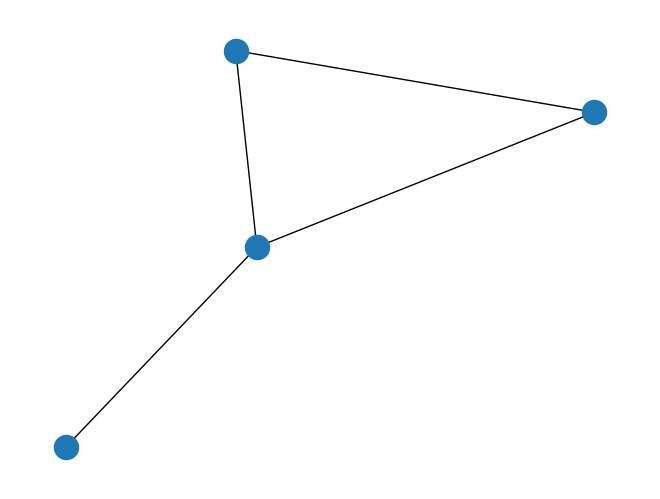

In [ ]:
# random, connected graph
NumberOfVerticies, EdgeProbability = 4, 5e-1
Graph = nx.erdos_renyi_graph(NumberOfVerticies, EdgeProbability)
GraphLaplacian = np.array(nx.laplacian_matrix(Graph).toarray())
while NumberOfVerticies != np.linalg.matrix_rank(GraphLaplacian) + 1:
    Graph = nx.erdos_renyi_graph(NumberOfVerticies, EdgeProbability)
    GraphLaplacian = np.array(nx.laplacian_matrix(Graph).toarray())
nx.draw(Graph, with_labels=False)

# number of edges & the Erdos-Edwards bound
NumberOfEdges = np.trace(GraphLaplacian) // 2
threshold = ErdosEdwards = int(np.ceil((2 * NumberOfEdges + NumberOfVerticies - 1)/4))

# let's get rid of the vertex with the highest degree
maxdegvertex = np.where(np.diag(GraphLaplacian) == max(np.diag(GraphLaplacian)))[0][0]

if maxdegvertex + 1 != NumberOfVerticies:
    GraphLaplacian[[maxdegvertex, -1], :] = GraphLaplacian[[-1, maxdegvertex], :]
    GraphLaplacian[:, [maxdegvertex, -1]] = GraphLaplacian[:, [-1, maxdegvertex]]

Q = GraphLaplacian[np.ix_(np.arange(NumberOfVerticies - 1), np.arange(NumberOfVerticies - 1))]

# cut-function and MaxCut
cuts, MaxCut = {}, 0
for x in range(pow(2, len(Q))):
    conf = np.array([(x >> i)&1 for i in range(len(Q))])
    cuts[x] = np.matmul(conf, np.matmul(Q, np.transpose(conf)))
    MaxCut = max(MaxCut, cuts[x])

# cut disctibution and ratios
random_chance, Lambda, dp = {i: 0 for i in range(MaxCut + 1)}, 0, pow(2, 1 - NumberOfVerticies)
for _, cut in cuts.items():
    random_chance[cut] += dp
    if cut >= threshold:
        Lambda += dp

m = NumberOfEdges / 2
sigma = np.sqrt(np.sum([pow(cut - m, 2) * random_chance[cut] for cut in random_chance]))
digits = 1 + int(np.ceil(np.log2(max(ErdosEdwards, NumberOfEdges + 1 - ErdosEdwards)))) if NumberOfVerticies > 2 else 2

In [ ]:
P = 0.8 # lower bound for the target probability
delta, l, TargetProbability = GroverParameterOptimizer(P, Lambda, 10)
print(f"MaxCut\tthreshold\tLambda\ttarget probability\tdelta\tl\tdigits\n{MaxCut}\t{threshold}\t\t{np.round(Lambda, 2)}\t{TargetProbability:.2%}\t\t\t{np.round(delta, 2)}\t{l}\t{digits}")

MaxCut	threshold	Lambda	target probability	delta	l	digits
3	3		0.38	100.00%			0.51	1	3


### simulation:

In [ ]:
noise = True
#noise = False

print(f"\ncomputation with Grover Fixed Point Search...\n")
start_time = time.time()
psi, qc = GroverForQUBO(Q, digits, threshold, delta, Lambda, noise)
end_time = time.time()
print(f"done in {np.round(end_time - start_time, 2)} seconds\n")


computation with Grover Fixed Point Search...

done in 1.96 seconds



In [ ]:
distribution, success = {cut: np.sum([p if cuts[x] == cut else 0 for x, p in enumerate(psi)]) for cut in range(MaxCut + 1)}, np.sum([p if cuts[x] >= threshold else 0 for x, p in enumerate(psi)])
M, var = np.sum([cut * distribution[cut] for cut in distribution]), np.sum([cut * cut * distribution[cut] for cut in distribution])
var, difference = np.sqrt(var - M**2), {cut: distribution[cut] - random_chance[cut] for cut in range(MaxCut + 1)}
sign_m, sign_sigma = "+" if M >= m else "-", "+" if var >= sigma else "-"

s = f"simulation with noise\n" if noise else f"simulation without noise\n"
s += f"\nthe graph:\n----------\nMaxCut\t\t\t= {MaxCut}\nnumber of edges\t\t= {NumberOfEdges}\nErdős-Edwards bound\t= {ErdosEdwards}\nthreshold\t\t= {threshold} ({threshold/MaxCut:.1%} of Maxcut)\n\nthe graph Laplacian:\n--------------------\n\n"
s += f"".join([f"{row.view()}\n" for row in GraphLaplacian])
s += f"\nGrover parameters:\n------------------\nLambda\t= {np.round(Lambda, 2)}\ndelta\t= {np.round(delta, 2)}\nl\t= {l}\n\nresults with Grover:\n--------------------\n\n"
s += f"expectation\t= {np.round(M, 2)}\t({m} {sign_m} {np.round(abs(M - m), 2)})\nvariance\t= {np.round(var, 2)}\t({np.round(sigma, 1)} {sign_sigma} {np.round(abs(var - sigma), 2)})\n\nsuccess probability = {success:.2%} (theoretical value = {TargetProbability:.2%}, random chance = {Lambda:.2%})\n"
print(s)

simulation with noise

the graph:
----------
MaxCut			= 3
number of edges		= 4
Erdős-Edwards bound	= 3
threshold		= 3 (100.0% of Maxcut)

the graph Laplacian:
--------------------

[ 2 -1  0 -1]
[-1  2  0 -1]
[ 0  0  1 -1]
[-1 -1 -1  3]

Grover parameters:
------------------
Lambda	= 0.38
delta	= 0.51
l	= 1

results with Grover:
--------------------

expectation	= 2.18	(2.0 + 0.18)
variance	= 1.0	(1.0 - 0.0)

success probability = 50.23% (theoretical value = 100.00%, random chance = 37.50%)



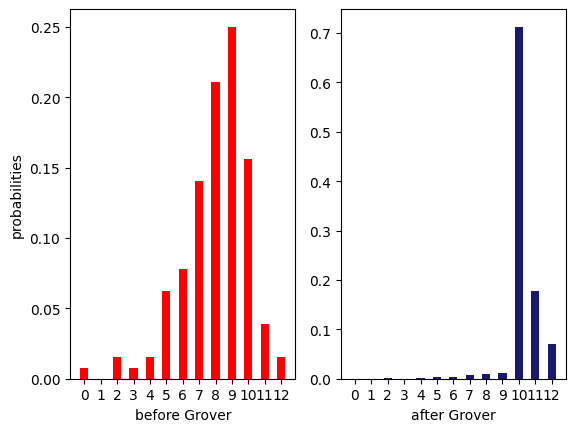

In [ ]:
fig, axs = plt.subplots(1, 2)

axs[0].bar(random_chance.keys(),
           random_chance.values(),
           width=0.5,
           color="red",
           tick_label=np.arange(MaxCut + 1))
axs[0].set(xlabel=f"before Grover", ylabel=f"probabilities")

axs[1].bar(distribution.keys(),
           distribution.values(),
           width=0.5,
           color="midnightblue",
           tick_label=np.arange(MaxCut + 1))
axs[1].set(xlabel=f"after Grover")

plt.show()

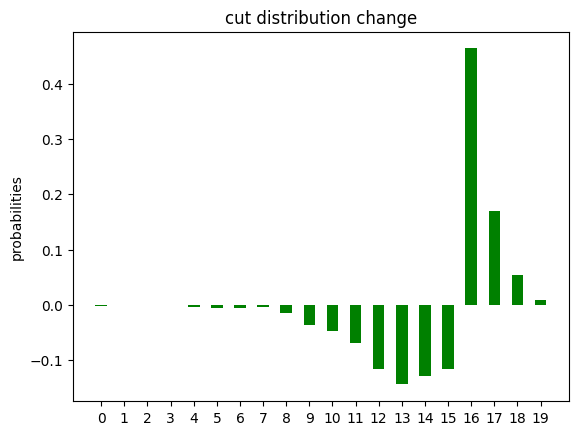

In [ ]:
plt.bar(difference.keys(),
        difference.values(),
        width=0.5,
        color="green",
        tick_label=np.arange(MaxCut + 1))
plt.title(f"cut distribution change")
plt.ylabel(f"probabilities")
plt.show()

# portfolio optimization

# Appendix: Grover parameters

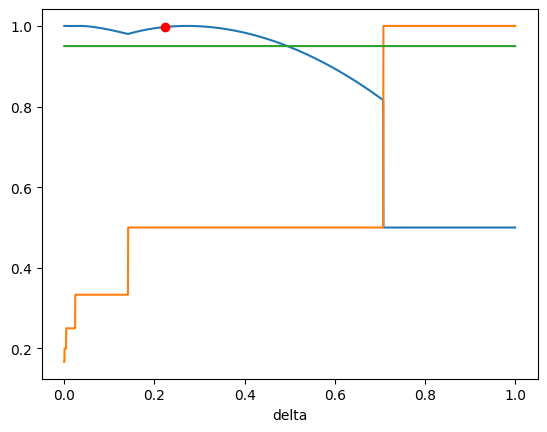

In [ ]:
Lambda = 5e-1
N = 12
step = pow(2, - N)
prob = 0.95

deltas = np.arange(step, 1 - step, step, dtype=float)
P = np.zeros(len(deltas), dtype=float)

simplicity = np.ones(len(deltas), dtype=float)
treshold = prob * np.ones(len(deltas), dtype=float)

for i, delta in enumerate(deltas):
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2
    simplicity[i] = 1/(l+1)
    P[i] = Lambda if l == 0 else 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)

plt.xlabel(f"delta")
plt.plot(deltas,P)
plt.plot(deltas,simplicity)
plt.plot(deltas,treshold)
delta_Y = np.sqrt(1-prob)
l_Y = int(np.ceil(np.arccosh(1 / delta_Y) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2
plt.plot(delta_Y, 1 - pow(delta_Y * Chebyshev(Chebyshev(1 / delta_Y, 1 / (2 * l_Y + 1)) * np.sqrt(1 - Lambda), 2 * l_Y + 1), 2), "ro")
plt.show()

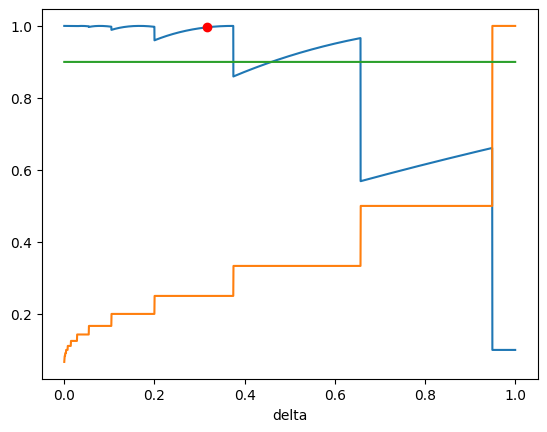

In [ ]:
Lambda = 1e-1
N = 12
step = pow(2, - N)
prob = 0.9

deltas = np.arange(step, 1 - step, step, dtype=float)
P = np.zeros(len(deltas), dtype=float)

simplicity = np.ones(len(deltas), dtype=float)
treshold = prob * np.ones(len(deltas), dtype=float)

for i, delta in enumerate(deltas):
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2
    simplicity[i] = 1/(l+1)
    P[i] = Lambda if l == 0 else 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)

plt.xlabel(f"delta")
plt.plot(deltas,P)
plt.plot(deltas,simplicity)
plt.plot(deltas,treshold)
delta_Y = np.sqrt(1-prob)
l_Y = int(np.ceil(np.arccosh(1 / delta_Y) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2
plt.plot(delta_Y, 1 - pow(delta_Y * Chebyshev(Chebyshev(1 / delta_Y, 1 / (2 * l_Y + 1)) * np.sqrt(1 - Lambda), 2 * l_Y + 1), 2), "ro")
plt.show()

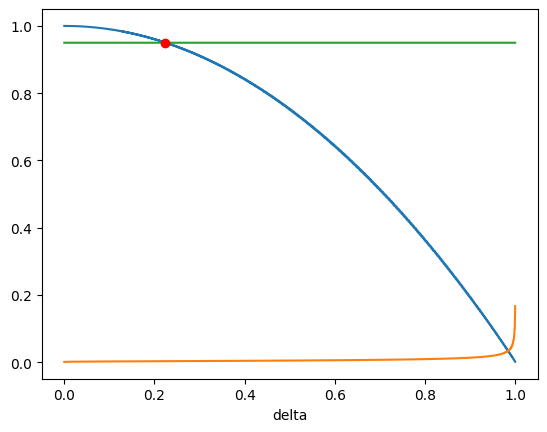

In [ ]:
Lambda = 1e-5
N = 12
step = pow(2, - N)
prob = 0.95

deltas = np.arange(step, 1 - step, step, dtype=float)
P = np.zeros(len(deltas), dtype=float)

simplicity = np.ones(len(deltas), dtype=float)
treshold = prob * np.ones(len(deltas), dtype=float)

for i, delta in enumerate(deltas):
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2
    simplicity[i] = 1/(l+1)
    P[i] = Lambda if l == 0 else 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)

plt.xlabel(f"delta")
plt.plot(deltas,P)
plt.plot(deltas,simplicity)
plt.plot(deltas,treshold)
delta_Y = np.sqrt(1-prob)
l_Y = int(np.ceil(np.arccosh(1 / delta_Y) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2
plt.plot(delta_Y, 1 - pow(delta_Y * Chebyshev(Chebyshev(1 / delta_Y, 1 / (2 * l_Y + 1)) * np.sqrt(1 - Lambda), 2 * l_Y + 1), 2), "ro")
plt.show()

In [ ]:
gate_count = { qubit: 0 for qubit in qc.qubits }
total_gate_count = 0

for gate in qc.data:
    for qubit in gate.qubits:
        gate_count[qubit] += 1
        total_gate_count += 1

gate_count, total_gate_count, qc.depth()

({Qubit(QuantumRegister(3, 'x'), 0): 36,
  Qubit(QuantumRegister(3, 'x'), 1): 52,
  Qubit(QuantumRegister(3, 'x'), 2): 25,
  Qubit(QuantumRegister(3, 'y'), 0): 26,
  Qubit(QuantumRegister(3, 'y'), 1): 23,
  Qubit(QuantumRegister(3, 'y'), 2): 24},
 186,
 92)

In [ ]:
gate_count = { qubit: 0 for qubit in qc.qubits }
total_gate_count = 0

for gate in qc.data:
    for qubit in gate.qubits:
        gate_count[qubit] += 1
        total_gate_count += 1

gate_count, total_gate_count, qc.depth()

({Qubit(QuantumRegister(11, 'x'), 0): 57,
  Qubit(QuantumRegister(11, 'x'), 1): 97,
  Qubit(QuantumRegister(11, 'x'), 2): 97,
  Qubit(QuantumRegister(11, 'x'), 3): 101,
  Qubit(QuantumRegister(11, 'x'), 4): 97,
  Qubit(QuantumRegister(11, 'x'), 5): 209,
  Qubit(QuantumRegister(11, 'x'), 6): 169,
  Qubit(QuantumRegister(11, 'x'), 7): 129,
  Qubit(QuantumRegister(11, 'x'), 8): 133,
  Qubit(QuantumRegister(11, 'x'), 9): 205,
  Qubit(QuantumRegister(11, 'x'), 10): 201,
  Qubit(QuantumRegister(6, 'y'), 0): 172,
  Qubit(QuantumRegister(6, 'y'), 1): 169,
  Qubit(QuantumRegister(6, 'y'), 2): 167,
  Qubit(QuantumRegister(6, 'y'), 3): 165,
  Qubit(QuantumRegister(6, 'y'), 4): 163,
  Qubit(QuantumRegister(6, 'y'), 5): 161},
 2492,
 1159)